## Exploratory Data Analysis

In [1]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [2]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [3]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<div class="span5 alert alert-info">
<h2>RFM Scoring</h2>
</div>

<h4>Functions</h4>

In [4]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    PrintKmeansInertiaGraphWithArray(dataFrame, [column])
    
def PrintKmeansInertiaGraphWithArray(dataFrame, columns, title=None):
    sse={}
    columnDF = dataFrame[columns]
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    if(title != None):
        plt.title(title)
    elif(len(columns)==1):
        plt.title("KMeans for {0}".format(str(columns[0])))
    else:
        plt.title("KMeans for {0}".format(", ".join([str(x) for x in columns])))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.ylabel("KMeans Inertia")
    plt.xlabel("K, Number of clusters")
    plt.show()
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
def PerformKMeansWithArray(dataFrame, columns, numClusters, clusterName, sub=None):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[columns])
    clusterCol = '{0}'.format(clusterName)
    clusters = kmeans.predict(dataFrame[columns])
    if sub!=None:
        clusters = [sub+str(x) for x in clusters]
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
        
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<div class="span5 alert alert-info">
<h3>Buyers</h3>
</div>

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Buyer_Recency, dtype: float64


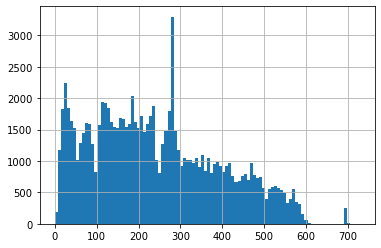

In [5]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Buyer_Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Buyer_Recency']])

print(buyers['Buyer_Recency'].describe())
buyers.Buyer_Recency.sort_values().hist(bins=100)
plt.show()


In [6]:
buyerMaxPurchase

,CustomerUniqueID,MaxPurchaseDate,Buyer_Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292
...,...,...,...
94462,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,451
94463,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,266
94464,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,572
94465,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,123


In [7]:
buyers

,CustomerUniqueID,Buyer_Recency
0,7c396fd4830fd04220f754e42b4e5bff,335
1,af07308b275d755c9edb36a90c618231,40
2,3a653a41f6f9fc3d2a113cf8398680e8,26
3,7c142cf63193a1473d2e66489a9ae977,288
4,72632f0f9dd73dfee390c9b22eb56dd6,201
...,...,...
94462,6359f309b166b0196dbf7ad2ac62bb5a,542
94463,da62f9e57a76d978d02ab5362c509660,208
94464,737520a9aad80b3fbbdad19b66b37b30,371
94465,5097a5312c8b157bb7be58ae360ef43c,237


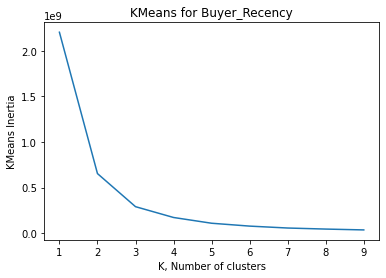

In [8]:
PrintKmeansInertiaGraph(buyers,'Buyer_Recency')

In [9]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Buyer_Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('Buyer_RecencyCluster', 'Buyer_Recency', buyers, False)

<h4>Frequency</h4>

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Buyer_Frequency, dtype: float64


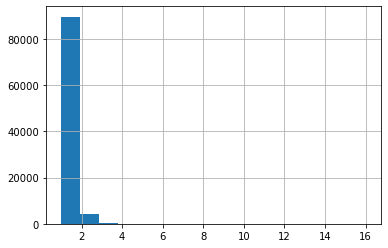

In [10]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Buyer_Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Buyer_Frequency'].describe())
buyers.Buyer_Frequency.sort_values().hist(bins=16)
plt.show()

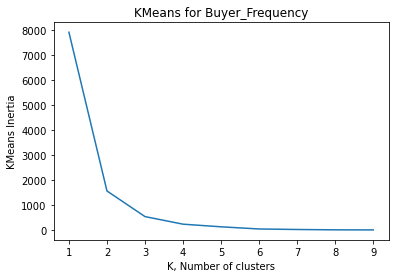

In [11]:
PrintKmeansInertiaGraph(buyers,'Buyer_Frequency')

In [12]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Buyer_Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('Buyer_FrequencyCluster', 'Buyer_Frequency', buyers, True)

<h4>Revenue</h4>

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Buyer_Revenue, dtype: float64


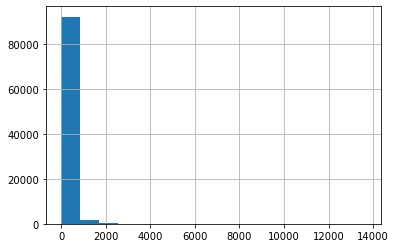

In [13]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Buyer_Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Buyer_Revenue'].describe())
buyers.Buyer_Revenue.sort_values().hist(bins=16)
plt.show()

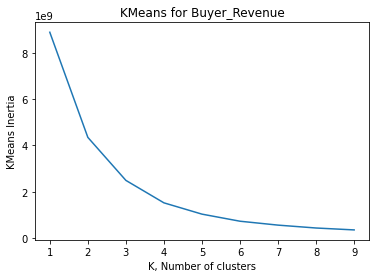

In [14]:
PrintKmeansInertiaGraph(buyers,'Buyer_Revenue')

In [15]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Buyer_Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('Buyer_RevenueCluster', 'Buyer_Revenue', buyers, True)

<h4>Scale RFM and Cluster</h4>

In [16]:
sub = buyers[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue','CustomerUniqueID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Buyer_Recency']/sub['Buyer_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Buyer_Frequency']/sub['Buyer_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Buyer_Revenue']/sub['Buyer_Revenue'].max(),axis=1))

sub = sub.assign(scale_recency_norm=sub.apply(lambda x: (x['scale_recency']-sub['scale_recency'].mean())/sub['scale_recency'].std(),axis=1))
sub = sub.assign(scale_frequency_norm=sub.apply(lambda x: (x['scale_frequency']-sub['scale_frequency'].mean())/sub['scale_frequency'].std(),axis=1))
sub = sub.assign(scale_revenue_norm=sub.apply(lambda x: (x['scale_revenue']-sub['scale_revenue'].mean())/sub['scale_revenue'].std(),axis=1))

sub = sub.assign(Buyer_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))

sub.columns

Index(['Buyer_Recency', 'Buyer_Frequency', 'Buyer_Revenue', 'CustomerUniqueID',
       'scale_recency', 'scale_frequency', 'scale_revenue',
       'scale_recency_norm', 'scale_frequency_norm', 'scale_revenue_norm',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')

In [17]:
sub[['scale_recency_norm','scale_frequency_norm','scale_revenue_norm']].describe()

,scale_recency_norm,scale_frequency_norm,scale_revenue_norm
count,9.446700e+04,9.446700e+04,9.446700e+04
mean,-3.548901e-14,1.221052e-13,2.912663e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.183575e+00,-2.107241e-01,-5.963686e-01
25%,-7.081747e-01,-2.107241e-01,-3.901887e-01
50%,1.235073e-01,-2.107241e-01,-2.414640e-01
75%,8.111184e-01,-2.107241e-01,1.776895e-02
max,1.583862e+00,5.160207e+01,4.395935e+01


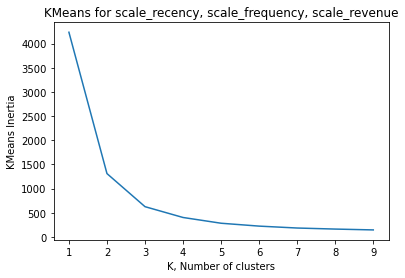

In [18]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [19]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 6, 'Buyer_RFM_cluster')

sub.groupby('Buyer_RFM_cluster')[['scale_recency','scale_frequency','scale_revenue']].mean().reset_index()

buyers = buyers.merge(sub[['Buyer_RFM_cluster','CustomerUniqueID','Buyer_Overall_RFM_Scaled']], on='CustomerUniqueID')

In [20]:
sub.groupby('Buyer_RFM_cluster')[['scale_recency','scale_frequency','scale_revenue']].mean().reset_index()

,Buyer_RFM_cluster,scale_recency,scale_frequency,scale_revenue
0,0,0.713586,0.066210,0.012485
1,1,0.280382,0.065454,0.013322
2,2,0.820607,0.066695,0.014127
3,3,0.595940,0.066161,0.013497
4,4,0.936729,0.066720,0.013629
5,5,0.448219,0.066264,0.013196


In [21]:
print(buyers.columns)
buyers = clustersInOrder('Buyer_RFM_cluster', 'Buyer_Overall_RFM_Scaled', buyers, True)

Index(['CustomerUniqueID', 'Buyer_Recency', 'Buyer_RecencyCluster',
       'Buyer_Frequency', 'Buyer_FrequencyCluster', 'Buyer_Revenue',
       'Buyer_RevenueCluster', 'Buyer_RFM_cluster',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')


In [22]:
buyers.groupby('Buyer_RFM_cluster')[['Buyer_RevenueCluster']].count()

,Buyer_RevenueCluster
Buyer_RFM_cluster,
0,10219
1,13831
2,17360
3,17840
4,17624
5,17593


<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [23]:
#calculate overall score and use mean() to see details
buyers['Buyer_OverallRFMScore'] = buyers['Buyer_RecencyCluster'] + buyers['Buyer_FrequencyCluster'] + buyers['Buyer_RevenueCluster']
buyers['Buyer_OverallRFM_Raw'] = buyers['Buyer_Recency'] + buyers['Buyer_Frequency'] + buyers['Buyer_Revenue']

buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']].mean()


,Buyer_Recency,Buyer_Frequency,Buyer_Revenue
Buyer_OverallRFMScore,,,
0,486.663311,1.000000,99.039346
1,335.639417,1.012381,125.317256
2,211.688372,1.029942,147.651778
3,96.443346,1.047355,171.845734
4,110.989366,1.300130,483.602628
5,110.011311,1.697937,893.757685
6,103.953157,2.207739,1487.894868
7,102.946667,2.866667,2482.782800
8,85.833333,4.208333,3333.663125


In [24]:
buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency']].count()

,Buyer_Recency
Buyer_OverallRFMScore,
0,13710
1,21970
2,26384
3,25594
4,4608
5,1503
6,491
7,150
8,48


In [25]:
#Assign labels
buyers['Buyer_RFM_Ranking'] = '0) Lowest - Overall = 0'
buyers.loc[buyers['Buyer_OverallRFMScore']>=1,'Buyer_RFM_Ranking'] ='1) Low - Overall > 0' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=3, 'Buyer_RFM_Ranking'] = '2)Medium - Overall > 2' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=6, 'Buyer_RFM_Ranking'] = '3) High - Overall > 5' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=8, 'Buyer_RFM_Ranking'] = '4) Highest - Overall > 7' 

In [26]:
buyers.groupby('Buyer_RFM_Ranking')[['Buyer_Recency']].count()

,Buyer_Recency
Buyer_RFM_Ranking,
0) Lowest - Overall = 0,13710
1) Low - Overall > 0,48354
2)Medium - Overall > 2,31705
3) High - Overall > 5,641
4) Highest - Overall > 7,57


In [27]:
buyers.head()

,CustomerUniqueID,Buyer_Recency,Buyer_RecencyCluster,Buyer_Frequency,Buyer_FrequencyCluster,Buyer_Revenue,Buyer_RevenueCluster,Buyer_Overall_RFM_Scaled,Buyer_RFM_cluster,Buyer_OverallRFMScore,Buyer_OverallRFM_Raw,Buyer_RFM_Ranking
0,7c396fd4830fd04220f754e42b4e5bff,335,1,2,1,82.82,0,0.670896,2,2,419.82,1) Low - Overall > 0
1,0a5df23b922b9998bb7378f1ac03c98a,338,1,2,1,193.83,0,0.674900,2,2,533.83,1) Low - Overall > 0
2,95cfb39a7e263160308a934e42cfc4e0,287,1,2,1,122.05,0,0.739701,2,2,411.05,1) Low - Overall > 0
3,646d643b4ac1184e383341f8896c3dc8,286,1,2,1,178.04,0,0.745173,2,2,466.04,1) Low - Overall > 0
4,6457b2cb5462c1217e8e6d36b0ff39d2,288,1,2,1,171.00,0,0.741910,2,2,461.00,1) Low - Overall > 0


<div class="span5 alert alert-info">
<h3>Sellers</h3>
</div>

<h4>Recency</h4>

count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Seller_Recency, dtype: float64


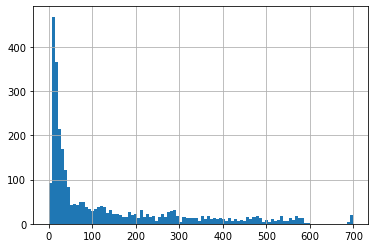

In [28]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Seller_Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Seller_Recency']])

print(sellers['Seller_Recency'].describe())
sellers.Seller_Recency.sort_values().hist(bins=100)
plt.show()

<h4>Frequency</h4>

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Seller_Frequency, dtype: float64


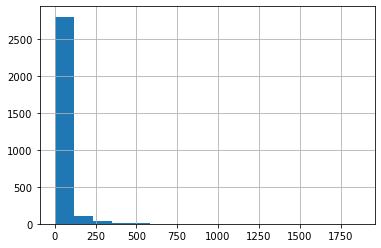

In [29]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Seller_Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Seller_Frequency'].describe())
sellers.Seller_Frequency.sort_values().hist(bins=16)
plt.show()

<h4>Revenue</h4>

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Seller_Revenue, dtype: float64


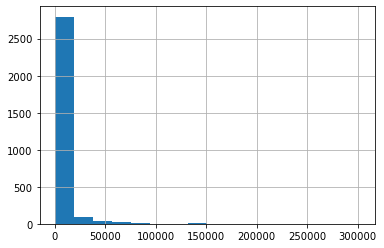

In [30]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Seller_Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Seller_Revenue'].describe())
sellers.Seller_Revenue.sort_values().hist(bins=16)
plt.show()

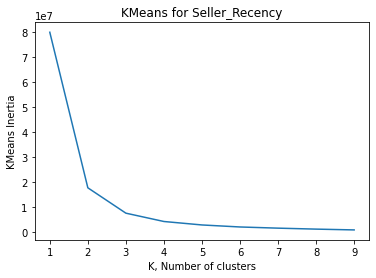

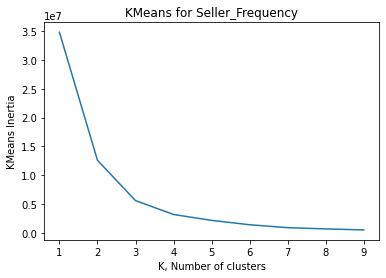

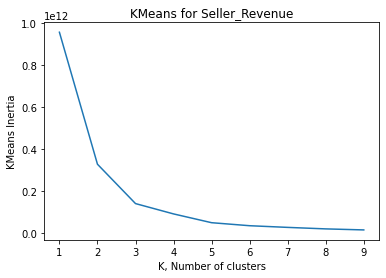

In [31]:

PrintKmeansInertiaGraph(sellers,'Seller_Recency')
PrintKmeansInertiaGraph(sellers,'Seller_Frequency')
PrintKmeansInertiaGraph(sellers,'Seller_Revenue')

In [32]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RecencyCluster', 'Seller_Recency', sellers, False)

print(sellers.groupby('Seller_RecencyCluster').mean())

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Seller_Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('Seller_FrequencyCluster', 'Seller_Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RevenueCluster', 'Seller_Revenue', sellers, True)

                       Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_RecencyCluster                                                  
0                          525.810909          3.876364      845.615345
1                          318.817708          9.203125     1661.556224
2                          156.729885         15.829502     3194.718927
3                           28.094655         48.644766     8206.478524


<h4>Scale RFM and Cluster</h4>

In [33]:
sub = sellers[['Seller_Recency','Seller_Frequency','Seller_Revenue','SellerID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Seller_Recency']/sub['Seller_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Seller_Frequency']/sub['Seller_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Seller_Revenue']/sub['Seller_Revenue'].max(),axis=1))

sub = sub.assign(Seller_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))


sub.head()

,Seller_Recency,Seller_Frequency,Seller_Revenue,SellerID,scale_recency,scale_frequency,scale_revenue,Seller_Overall_RFM_Scaled
0,300,53,3177.71,3504c0cb71d7fa48d967e0e4c94d59d9,0.570815,0.028418,0.010538,0.609772
1,345,6,1125.49,633ecdf879b94b5337cca303328e4a25,0.506438,0.003217,0.003732,0.513387
2,277,10,2062.45,f5f46307a4d15880ca14fab4ad9dfc9b,0.603720,0.005362,0.006840,0.615921
3,339,26,2462.81,c8417879a15366a17c30af34c798c332,0.515021,0.013941,0.008167,0.537130
4,284,40,2870.32,6df688df543f90e9b38f4319e75a9d88,0.593705,0.021448,0.009519,0.624672


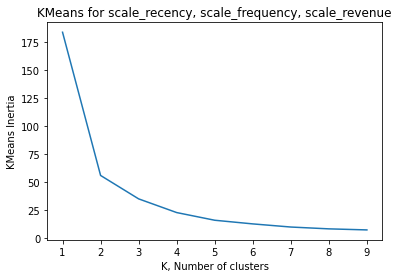

In [34]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [35]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 5, 'Seller_RFM_cluster')
sellers = sellers.merge(sub[['Seller_RFM_cluster','SellerID','Seller_Overall_RFM_Scaled']], on='SellerID')

sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
sellers['Seller_OverallRFM_Raw'] = sellers['Seller_Recency'] + sellers['Seller_Frequency'] + sellers['Seller_Revenue']
sellers.columns

Index(['SellerID', 'Seller_Recency', 'Seller_Frequency', 'Seller_Revenue',
       'Seller_RecencyCluster', 'Seller_FrequencyCluster',
       'Seller_RevenueCluster', 'Seller_RFM_cluster',
       'Seller_Overall_RFM_Scaled', 'Seller_OverallRFMScore',
       'Seller_OverallRFM_Raw'],
      dtype='object')

In [36]:
sellers = clustersInOrder('Seller_RFM_cluster', 'Seller_Overall_RFM_Scaled', sellers, True)

In [37]:
sellers.groupby('Seller_RFM_cluster')[['Seller_RevenueCluster']].count()

,Seller_RevenueCluster
Seller_RFM_cluster,
0,278
1,391
2,530
3,1755
4,23


<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [38]:
#calculate overall score and use mean() to see details
sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
sellers.groupby('Seller_OverallRFMScore')[['Seller_Recency','Seller_Frequency','Seller_Revenue']].mean()



,Seller_Recency,Seller_Frequency,Seller_Revenue
Seller_OverallRFMScore,,,
0,526.080586,3.542125,743.819670
1,318.686486,7.081081,1177.367649
2,161.903292,8.895062,1693.394198
3,33.464888,13.650281,2291.865049
4,34.441341,61.865922,13165.576704
5,23.320513,127.692308,20070.839359
6,22.560976,232.658537,46439.367073
7,14.851852,425.074074,53798.847037
8,22.625000,638.875000,128986.017500


In [39]:
sellers.groupby('Seller_OverallRFMScore')[['Seller_Revenue']].count()

,Seller_Revenue
Seller_OverallRFMScore,
0,273
1,370
2,486
3,1424
4,179
5,156
6,41
7,27
8,8


In [40]:
sellers['Seller_RFM_Ranking'] = '0) Lowest - Overall = 0'
sellers.loc[sellers['Seller_OverallRFMScore']>=1,'Seller_RFM_Ranking'] ='1) Low - Overall > 0' 
sellers.loc[sellers['Seller_OverallRFMScore']>=4, 'Seller_RFM_Ranking'] = '2) Medium - Overall > 4'
sellers.loc[sellers['Seller_OverallRFMScore']>=6, 'Seller_RFM_Ranking'] = '3) High - Overall > 6'

In [41]:
sellers.groupby('Seller_RFM_Ranking')[['Seller_Recency']].count()

,Seller_Recency
Seller_RFM_Ranking,
0) Lowest - Overall = 0,273
1) Low - Overall > 0,2280
2) Medium - Overall > 4,335
3) High - Overall > 6,89


<h4>Merge in RFM Clusters</h4>

In [42]:
OL_Data = OL_Data.merge(buyers, left_on='customer_unique_id', right_on='CustomerUniqueID')
OL_Data = OL_Data.merge(sellers, left_on='seller_id',right_on='SellerID')
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

<h3>Add Distance from Buyer to Seller</h3>

In [43]:
#calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
OL_Data['DistanceOfSale'] = OL_Data.apply(lambda x: distance(x.customer_latitude, x.customer_longitude, x.seller_latitude, x.seller_longitude) , axis=1)

In [44]:
OL_Data['DistanceOfSale'].describe()

count    99727.000000
mean       603.487296
std        596.949713
min          0.000000
25%        189.670210
50%        435.533645
75%        801.451936
max       8736.947618
Name: DistanceOfSale, dtype: float64

<div class="span5 alert alert-info">
<h3>Write out data</h3>
</div>

In [45]:
OL_Data.to_csv('./OLData_RFM_Metrics.csv')

<div class="span5 alert alert-info">
<h3>Buyer Sub Clusters </h3>
</div>

['1) Low - Overall > 0' '0) Lowest - Overall = 0' '2)Medium - Overall > 2'
 '3) High - Overall > 5' '4) Highest - Overall > 7']


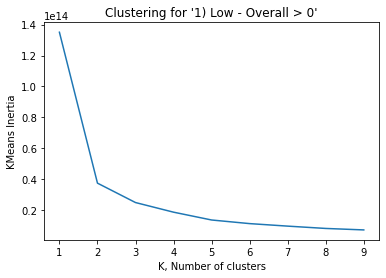

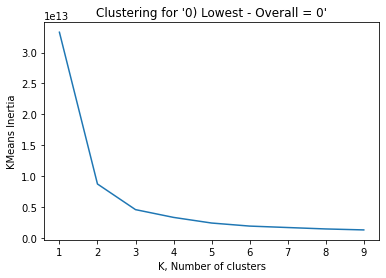

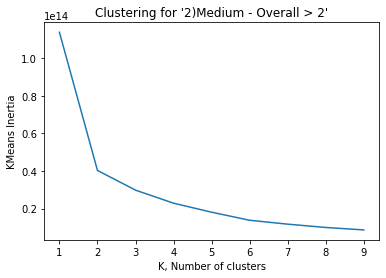

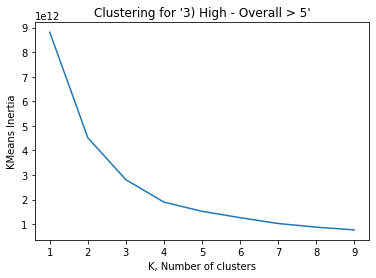

C:\Users\Karl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



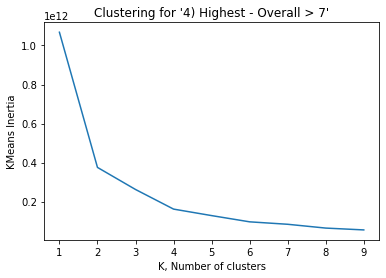

In [46]:
clusters={'0) Lowest - Overall = 0':3,
          '1) Low - Overall > 0':3,
          '2)Medium - Overall > 2':2,
          '3) High - Overall > 5':4,
          '4) Highest - Overall > 7':4}

print(OL_Data['Buyer_RFM_Ranking'].unique())

OL_Data_Sub = OL_Data.copy()
subData = pd.DataFrame({'order_id' : [], 'Buyer_RFM_Ranking_SubClusers':[]})

for t in OL_Data['Buyer_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Buyer_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols,"Clustering for \'{0}\'".format(t))
    PerformKMeansWithArray(subset, numcols, clusters[t], "Buyer_RFM_Ranking_SubClusers", t)
    subData = pd.concat([subData, subset[["order_id","Buyer_RFM_Ranking_SubClusers"]]], ignore_index=True)
    
OL_Data_Sub = OL_Data_Sub.merge(subData, on='order_id',how='left' )

<div class="span5 alert alert-info">
<h3>Seller Sub Clusters </h3>
</div>

['1) Low - Overall > 0' '2) Medium - Overall > 4' '3) High - Overall > 6'
 '0) Lowest - Overall = 0']


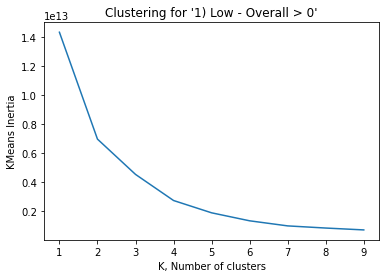

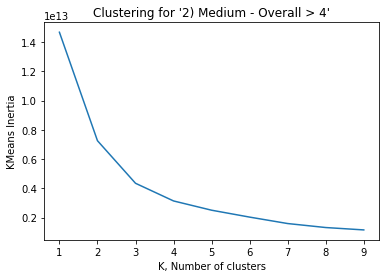

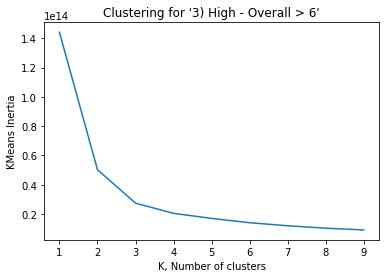

C:\Users\Karl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



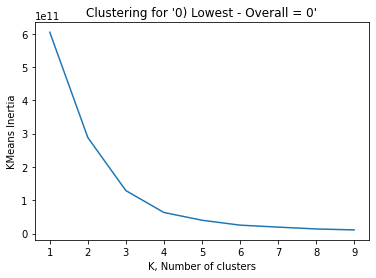

In [47]:
clusters={'1) Low - Overall > 0':4, '2) Medium - Overall > 4':4, '3) High - Overall > 6':4, '0) Lowest - Overall = 0':4}
print(OL_Data['Seller_RFM_Ranking'].unique())

subData = pd.DataFrame({'order_id' : [], 'Seller_RFM_Ranking_SubClusers':[]})
for t in OL_Data['Seller_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Seller_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols,"Clustering for \'{0}\'".format(t))
    PerformKMeansWithArray(subset, numcols, clusters[t], "Seller_RFM_Ranking_SubClusers", t)
    subData = pd.concat([subData, subset[["order_id","Seller_RFM_Ranking_SubClusers"]]], ignore_index=True)

OL_Data_Sub = OL_Data_Sub.merge(subData, on='order_id',how='left' )


<h4>Write Out Data For Tableau</h4>

In [48]:
OL_Data_Sub[["order_id","Buyer_RFM_Ranking_SubClusers","Seller_RFM_Ranking_SubClusers"]].to_csv('./OLData_SubClusters.csv')

<div class="span5 alert alert-info">
<h3>Lines from Seller To Buyer </h3>
</div>

In [49]:

AllOrderLines = []
for index, row in OL_Data.iterrows():
    originRow = {}
    destRow = {}
    
    originRow['Origin-Destination'] = 'Origin'
    destRow['Origin-Destination'] = 'Destination'

    idName = "{0}-{1}".format(row['customer_id'],index)
    originRow['PathId'] = idName
    destRow['PathId'] = idName

    originRow['Latitude'] = row['seller_latitude']
    originRow['Longitude'] = row['seller_longitude']
    destRow['Latitude'] = row['customer_latitude']
    destRow['Longitude'] =  row['customer_longitude']
    
    originRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']
    destRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']    
    originRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    destRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    
    AllOrderLines.append(originRow)
    AllOrderLines.append(destRow)
    
mapDf = pd.DataFrame(AllOrderLines)
mapDf.to_csv('./OrderMapData.csv')

<div class="span5 alert alert-info">
<h3>Tableau workbooks</h3>
</div>

[RFM Score Investigation](https://public.tableau.com/authoring/OL_Data_Metric_EDA/SellerGeo#1)

[Mapping of Olist Orders](https://public.tableau.com/app/profile/karl.deakyne/viz/OL_Data_Orders_Mapped/OrdersMapped)